In [1]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset using sklearn
from sklearn.datasets import fetch_openml
data = fetch_openml("parkinsons")

#Separating data into feature variable X and target variable y respectively
X=data['data']
y=data['target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Extracting the names of the features from data
features = data['feature_names']

#Splitting X & y into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=50)

from sklearn.svm import SVC
clf = SVC(probability=True, random_state=50).fit(X_train, y_train)

#Checking the model's performance on the test set
print('R2 score for the model on test set =', clf.score(X_test, y_test))

R2 score for the model on test set = 0.8717948717948718


In [2]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=X.shape[0],verbose=1,max_iter=1000, init_params='random',covariance_type='spherical', weight_concentration_prior_type='dirichlet_distribution', random_state=42)
bgmm.fit(X)
print(f"Number of unique clusters = {np.unique(bgmm.predict(X)).shape}")

#Finding cluster labels and probabilities
cluster_labels = bgmm.predict(X)
cluster_proba = bgmm.predict_proba(X)
mu = bgmm.means_
cov = bgmm.covariances_

from pprint import pprint
unique, counts = np.unique(cluster_labels, return_counts=True)
pprint(dict(zip(unique, counts)))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
Number of unique clusters = (8,)
{28: 10, 65: 32, 85: 3, 90: 29, 97: 4, 104: 85, 108: 26, 135: 6}


In [3]:
np.argwhere(cluster_labels==135).ravel()

array([ 21, 134, 135, 136, 137, 138], dtype=int64)

In [4]:
#Sampling from BGMM
idx = 133
arr = X[idx]

#Finding cluster for the given idx
cluster_label_arr = cluster_labels[idx]
cluster_proba_arr = cluster_proba[idx]
mu_arr = mu[cluster_label_arr]
cov_arr = cov[cluster_label_arr]

#from scipy.stats import multivariate_normal
from scipy.stats import multivariate_normal
distr = multivariate_normal(cov = cov_arr, mean = mu_arr)
X_surrogate = distr.rvs(size = 500)
y_surrogate = clf.predict_proba(X_surrogate)

In [5]:
from tqdm import tqdm
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, Lasso, Ridge

bgmm_stability_scores = []
bgmm_fidelity_scores = []
bgmm_mean_scores = []

samples_list = list(range(10, 91, 20)) + list(range(100, 1001, 100))
for num_samples in tqdm(samples_list):
    fidelity_score = 0
    scores = []
    for i in range(10):
        distr = multivariate_normal(cov = cov_arr, mean = mu_arr)
        X_surrogate = distr.rvs(size = num_samples)
        y_surrogate = clf.predict_proba(X_surrogate)
        bbox = Ridge().fit(X_surrogate, y_surrogate)

        bbox.fit(X_surrogate, y_surrogate)
#         plt.title(f"Iteration{i}, Surrogate fit = {bbox.score(X_surrogate, y_surrogate)}")
#         plt.stem(bbox.coef_/max(bbox.coef_))
#         plt.show()
        scores.append(bbox.coef_[int(y[idx])-1]/max(bbox.coef_[int(y[idx])-1]))
        fidelity_score+=bbox.score(X_surrogate, y_surrogate)
    rankings = rankdata(np.array(scores), axis=1)
    m = rankings.shape[0]
    n = rankings.shape[1]
    denom = m ** 2 * (n ** 3 - n)
    S = n * np.var(np.sum(rankings, axis=0))
    bgmm_stability_scores.append(12 * S / denom)
    bgmm_fidelity_scores.append(fidelity_score/10)
    bgmm_mean_scores.append(np.mean(scores,axis=0))


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.35it/s]


In [6]:
np.array(bgmm_mean_scores).shape

(15, 22)

In [7]:
from tqdm import tqdm
import lime.lime_tabular

lime_stability_scores = []
lime_fidelity_scores = []
lime_mean_scores = []

samples_list = list(range(10, 91, 20)) + list(range(100, 1001, 100))
for num_samples in tqdm(samples_list):
    fidelity_score = 0
    scores = []
    for i in range(10):
        explainer_lime = lime.lime_tabular.LimeTabularExplainer(X,
                                                            feature_names=features,
                                                            verbose=False, mode='classification')
        exp_lime = explainer_lime.explain_instance(X[idx], 
                                                   clf.predict_proba, 
                                                   num_features=X.shape[1], 
                                                   num_samples=num_samples)
        
#         plt.title(f"Iteration{i}, Surrogate fit = {bbox.score(X_surrogate, y_surrogate)}")
#         plt.stem(bbox.coef_/max(bbox.coef_))
#         plt.show()
        scores.append(np.array(exp_lime.as_list())[:,1].astype('float'))
        fidelity_score+=exp_lime.score
    
    rankings = rankdata(np.array(scores), axis=1)
    m = rankings.shape[0]
    n = rankings.shape[1]
    denom = m ** 2 * (n ** 3 - n)
    S = n * np.var(np.sum(rankings, axis=0))
    lime_stability_scores.append(12 * S / denom)
    lime_fidelity_scores.append(fidelity_score/10)
    lime_mean_scores.append(np.mean(scores,axis=0))


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:19<00:00,  5.31s/it]


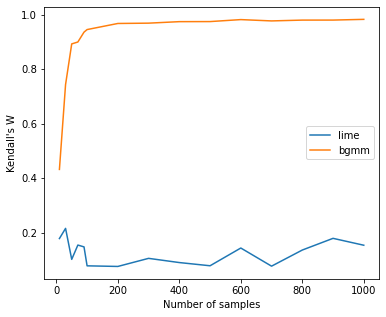

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 6, 5
plt.plot(samples_list,lime_stability_scores,label='lime')
plt.plot(samples_list,bgmm_stability_scores, label='bgmm')
plt.xlabel("Number of samples")
plt.ylabel("Kendall's W")
plt.legend()
plt.savefig("results/stability_parkinsons.png",dpi=300)

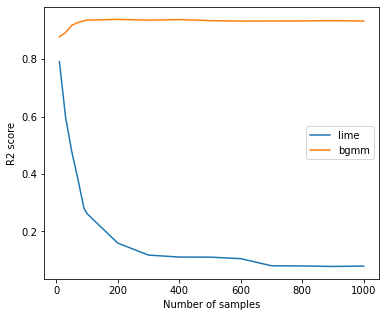

In [9]:
plt.plot(samples_list,lime_fidelity_scores,label='lime')
plt.plot(samples_list,bgmm_fidelity_scores,label='bgmm')
plt.xlabel("Number of samples")
plt.ylabel("R2 score")
plt.legend()
plt.savefig("results/fidelity_parkinsons.png",dpi=300)